In [1]:
!pip install np_utils

     |████████████████████████████████| 61 kB 344 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=815c841db1f39a501b9d189cc6812ade84732813f0938fbeb321b90d6c504298
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
from tqdm import tqdm, notebook

In [4]:
Crema = ["/kaggle/input/emotion-detection-dataset/angry/","/kaggle/input/emotion-detection-dataset/disgusting/","/kaggle/input/emotion-detection-dataset/fear/","/kaggle/input/emotion-detection-dataset/happy/","/kaggle/input/emotion-detection-dataset/neutral/","/kaggle/input/emotion-detection-dataset/sad/"]

In [5]:
file_emotion = []
file_path = []
for i in Crema:
    crema_directory_list = os.listdir(i)
    for file in crema_directory_list:
        if file != 'desktop.ini':
            # storing file paths
            file_path.append(i +file)
        else:
            print('not gonna append')
        # storing file emotions
        part=file.split('_')
        try:
            if part[2] == 'SAD':
                file_emotion.append('sad')
            elif part[2] == 'ANG':
                file_emotion.append('angry')
            elif part[2] == 'DIS':
                file_emotion.append('disgust')
            elif part[2] == 'FEA':
                file_emotion.append('fear')
            elif part[2] == 'HAP':
                file_emotion.append('happy')
            elif part[2] == 'NEU':
                file_emotion.append('neutral')
            else:
                file_emotion.append('Unknown')
        except:
            print(part)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

not gonna append
['desktop.ini']
not gonna append
['desktop.ini']
not gonna append
['desktop.ini']
not gonna append
['desktop.ini']
not gonna append
['desktop.ini']


,Emotions,Path
0,angry,/kaggle/input/emotion-detection-dataset/angry/...
1,angry,/kaggle/input/emotion-detection-dataset/angry/...
2,angry,/kaggle/input/emotion-detection-dataset/angry/...
3,angry,/kaggle/input/emotion-detection-dataset/angry/...
4,angry,/kaggle/input/emotion-detection-dataset/angry/...


In [6]:
ls

__notebook__.ipynb


In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/kaggle/input/emotion-detection-dataset/angry/...
1,angry,/kaggle/input/emotion-detection-dataset/angry/...
2,angry,/kaggle/input/emotion-detection-dataset/angry/...
3,angry,/kaggle/input/emotion-detection-dataset/angry/...
4,angry,/kaggle/input/emotion-detection-dataset/angry/...


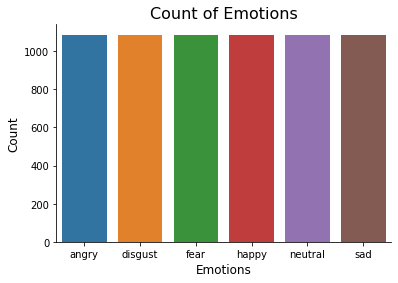

In [8]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
data_path['Emotions'].value_counts()

angry      1087
disgust    1087
fear       1087
happy      1087
neutral    1087
sad        1087
Name: Emotions, dtype: int64

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [12]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

6522it [37:07,  2.93it/s]


In [13]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.110802,0.490795,0.505013,0.469710,0.561363,0.636531,0.563674,0.523280,0.558596,0.708839,...,2.711551e-07,2.506912e-07,2.352728e-07,2.230817e-07,2.134433e-07,2.060598e-07,2.004179e-07,1.965473e-07,1.941202e-07,angry
1,0.296992,0.662722,0.677393,0.686170,0.753687,0.803746,0.718685,0.617828,0.649817,0.754733,...,6.520792e-02,6.238075e-02,6.510437e-02,6.627490e-02,6.685612e-02,6.659891e-02,6.144643e-02,6.231309e-02,6.651492e-02,angry
2,0.120331,0.479905,0.506866,0.450984,0.512692,0.611210,0.601978,0.522084,0.528140,0.633301,...,2.646588e-07,2.364683e-07,2.173610e-07,2.030144e-07,1.919180e-07,1.830629e-07,1.614937e-07,1.041743e-07,5.117198e-08,angry
3,0.051547,0.551136,0.600135,0.714214,0.736494,0.618028,0.464627,0.518613,0.602296,0.640959,...,2.636145e-06,2.447441e-06,2.304417e-06,2.190688e-06,2.100426e-06,2.031119e-06,1.978037e-06,1.941582e-06,1.918666e-06,angry
4,0.216556,0.684071,0.718757,0.799116,0.816782,0.741847,0.595640,0.585316,0.638125,0.653348,...,2.488688e-02,2.398640e-02,2.381795e-02,2.405162e-02,2.364923e-02,2.463325e-02,2.332164e-02,2.398399e-02,2.471325e-02,angry


In [14]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [15]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [16]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14674, 162), (14674, 6), (4892, 162), (4892, 6))

In [17]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14674, 162), (14674, 6), (4892, 162), (4892, 6))

In [18]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14674, 162, 1), (14674, 6), (4892, 162, 1), (4892, 6))

In [19]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

2022-03-24 11:02:24.853126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:02:24.936686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:02:24.937387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:02:24.938629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [20]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

2022-03-24 11:02:31.485023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-24 11:02:32.884223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


230/230 [==============================] - 9s 9ms/step - loss: 1.6273 - accuracy: 0.3056 - val_loss: 1.5238 - val_accuracy: 0.3518
Epoch 2/50
230/230 [==============================] - 2s 8ms/step - loss: 1.5309 - accuracy: 0.3561 - val_loss: 1.4898 - val_accuracy: 0.3622
Epoch 3/50
230/230 [==============================] - 2s 8ms/step - loss: 1.4950 - accuracy: 0.3769 - val_loss: 1.4918 - val_accuracy: 0.3876
Epoch 4/50
230/230 [==============================] - 2s 8ms/step - loss: 1.4666 - accuracy: 0.3895 - val_loss: 1.4216 - val_accuracy: 0.4203
Epoch 5/50
230/230 [==============================] - 2s 8ms/step - loss: 1.4475 - accuracy: 0.4047 - val_loss: 1.4099 - val_accuracy: 0.4215
Epoch 6/50
230/230 [==============================] - 2s 8ms/step - loss: 1.4259 - accuracy: 0.4126 - val_loss: 1.3917 - val_accuracy: 0.4272
Epoch 7/50
230/230 [==============================] - 2s 8ms/step - loss: 1.4021 - accuracy: 0.4278 - val_loss: 1.3822 - val_accuracy: 0.4399
Epoch 8/50
230/23

153/153 [==============================] - 0s 3ms/step - loss: 1.4209 - accuracy: 0.4941
Accuracy of our model on test data :  49.407196044921875 %


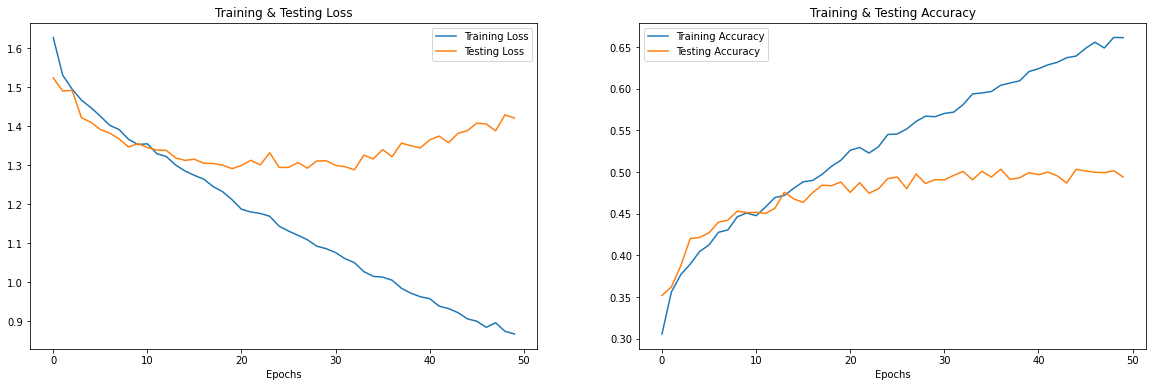

In [21]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [22]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [23]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,neutral,happy
2,neutral,sad
3,angry,happy
4,angry,angry
5,angry,angry
6,sad,sad
7,sad,disgust
8,disgust,disgust
9,sad,neutral


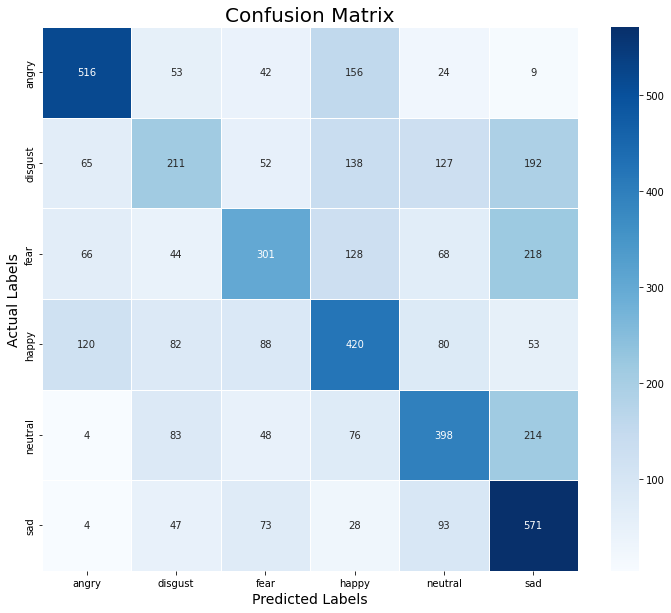

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.67      0.65      0.66       800
     disgust       0.41      0.27      0.32       785
        fear       0.50      0.36      0.42       825
       happy       0.44      0.50      0.47       843
     neutral       0.50      0.48      0.49       823
         sad       0.45      0.70      0.55       816

    accuracy                           0.49      4892
   macro avg       0.50      0.49      0.49      4892
weighted avg       0.50      0.49      0.49      4892

